# Identifying Transiting Planet Signals in a *Kepler* Light Curve
---

## Learning Goals

By the end of this tutorial, you will:

 - Understand the "Box Least Squares" (BLS) method for identifying transit signals.
 - Know how to use the Lightkurve `BoxLeastSquaresPeriodogram` to identify a transiting planet.
 - Be able to estimate the period, epoch, and duration of the transit.
 - Be able to plot the phase-folded transit light curve.
 - Be familiar with the interactive Box Least Squares periodogram in Lightkurve.

## Introduction

The *Kepler* and *TESS* missions are optimized for finding new transiting exoplanets. [Lightkurve](http://docs.lightkurve.org/) provides a suite of tools that help make the process of identifying and characterizing planets convenient and accessible.

In this tutorial, we will show you how to conduct your own search for transiting exoplanets in *Kepler* and *TESS* light curves. [Lightkurve](http://docs.lightkurve.org/) uses the [Astropy](https://www.astropy.org/) implementation of the Box Least Squares (BLS) method to identify transit signals. This tutorial demonstrates the basics of how to optimally use Lightkurve's BLS tools.

## Imports
This tutorial requires the [**Lightkurve**](http://docs.lightkurve.org/) package, which uses [**Matplotlib**](https://matplotlib.org/) for plotting.

In [1]:
import lightkurve as lk
%matplotlib inline

---

## 1. Downloading a Light Curve and Removing Long-Term Trends

As an example, we will download all available [*Kepler*](https://archive.stsci.edu/kepler) observations for a known multi-planet system, [Kepler-69](https://iopscience.iop.org/article/10.1088/0004-637X/768/2/101).

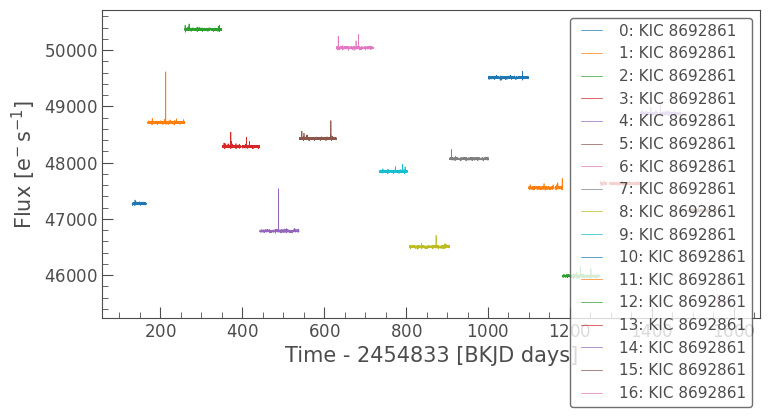

In [2]:
# Search for Kepler observations of Kepler-69
search_result = lk.search_lightcurve('Kepler-69', author='Kepler', cadence='long')
# Download all available Kepler light curves
lc_collection = search_result.download_all()
lc_collection.plot();

Each observation has a different offset, so in order to successfully search this light curve for transits, we first need to normalize and flatten the full observation. This can be performed on a stitched light curve. For more information about combining multiple observations of the same target, please see the companion tutorial on combining multiple quarters of *Kepler* data with Lightkurve.

In [3]:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 01,2009,Kepler,1800,kplr008692861,0.0
1,Kepler Quarter 02,2009,Kepler,1800,kplr008692861,0.0
2,Kepler Quarter 03,2009,Kepler,1800,kplr008692861,0.0
3,Kepler Quarter 04,2010,Kepler,1800,kplr008692861,0.0
4,Kepler Quarter 05,2010,Kepler,1800,kplr008692861,0.0
5,Kepler Quarter 06,2010,Kepler,1800,kplr008692861,0.0
6,Kepler Quarter 07,2010,Kepler,1800,kplr008692861,0.0
7,Kepler Quarter 10,2011,Kepler,1800,kplr008692861,0.0
8,Kepler Quarter 09,2011,Kepler,1800,kplr008692861,0.0


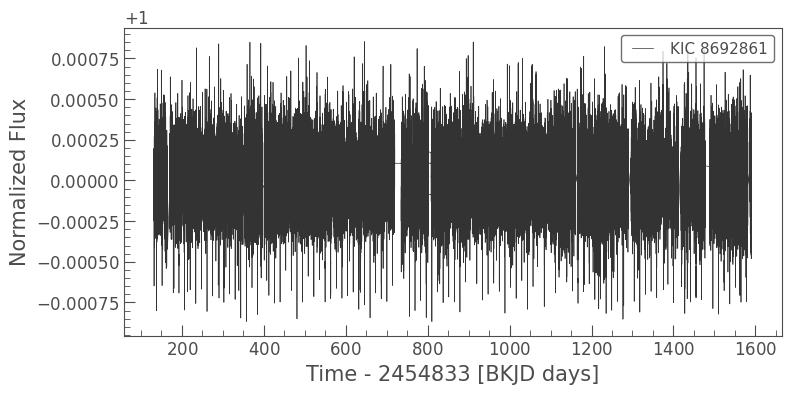

In [4]:
# Flatten the light curve 
lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
lc.plot();

## 2. The Box Least Squares Method for Finding Transiting Planets

The most common method used to identify transiting exoplanets is the Box Least Squares (BLS) periodogram analysis. BLS works by modeling a transit using an upside-down top hat with four parameters: period, duration, depth, and reference time. These can be seen in the figure below, from the `astropy.timeseries` implementation of BLS.

<img style="float: right;" src="https://docs.astropy.org/en/stable/timeseries/bls-1.png" alt="Box Least Squares" width="600px"/>

These parameters are then optimized by minimizing the square difference between the BLS transit model and the observation. For more information about BLS, please see the [Astropy documentation](https://docs.astropy.org/en/stable/timeseries/bls.html).

[Lightkurve]() has two types of periodogram available to anaylze periodic trends in light curves:
* `LombScarglePeriodogram`
* `BoxLeastSquaresPeriodogram`

Please see the companion tutorial on how to create periodograms and identify significant peaks for an example of the `LombScarglePeriodogram`.

## 3. Searching for Transiting Planets in a *Kepler* Light Curve Using BLS

To create a `BoxLeastSquaresPeriodogram`, use the `LightCurve` method `to_periodogram`, and pass in the string `'bls'` to specify the type of periodogram object you want to create. This method also optionally takes an array of periods (in days) to search, which we will set from 1–20 days to limit our search to short-period planets. We do so using the `numpy.linspace` function.

`period` contains 404720 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


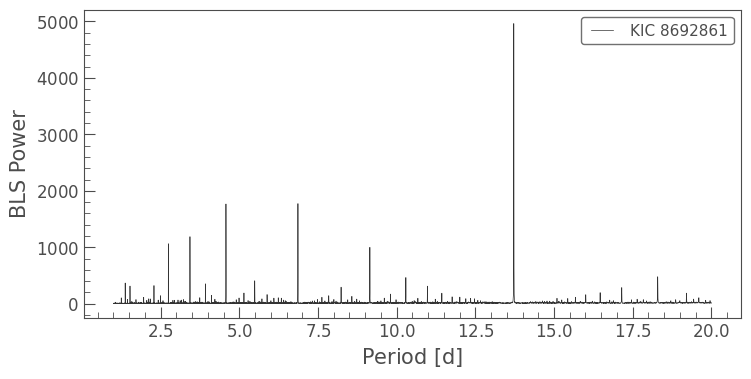

In [5]:
import numpy as np
# Create array of periods to search
period = np.linspace(1, 20, 10000)
# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=100);
bls.plot();

The plot above shows the power, or the likelihood of the BLS fit, for each of the periods in the array we passed in. This plot shows a handful of high-power peaks at discrete periods, which is a good sign that a transit has been identified. The highest power spike shows the most likely period, while the lower power spikes are fractional harmonics of the period, for example, 1/2, 1/3, 1/4, etc. 

We can pull out the most likely BLS parameters by taking their values at maximum power — we will refer to this transiting object as "planet b."

In [6]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

# Check the value for period
planet_b_period

<Quantity 13.72177218 d>

To confirm that this period and transit time (epoch) correspond to a transit signal, we can phase-fold the light curve using these values and plot it.

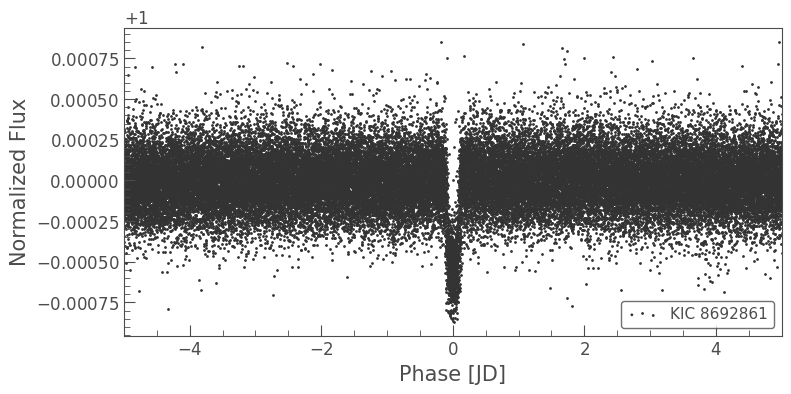

In [7]:
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-5, 5);

The phase-folded light curve shows a strong transit signal with the identified period and transit time of maximum BLS power.

## 4. Retrieving a Transit Model and Cadence Mask

The BLS periodogram has features that make it possible to search for multiple planets in the same system. If we want to identify additional transit signals, it will be much more convenient if we first remove the previously identified signal. This will prevent the high-power periodicity of the first planet, planet b, from dominating the BLS periodogram, and will allow us to find lower signal-to-noise ratio (SNR) transits.

We can create a cadence mask for the light curve using the transit parameters from the `BoxLeastSquaresPeriodogram`.

In [8]:
# Create a cadence mask using the BLS parameters
planet_b_mask = bls.get_transit_mask(period=planet_b_period, 
                                     transit_time=planet_b_t0, 
                                     duration=planet_b_dur)

Now, we can create a masked version of the light curve to search for additional transit signals. The light curve is shown below, with masked cadences marked in red.

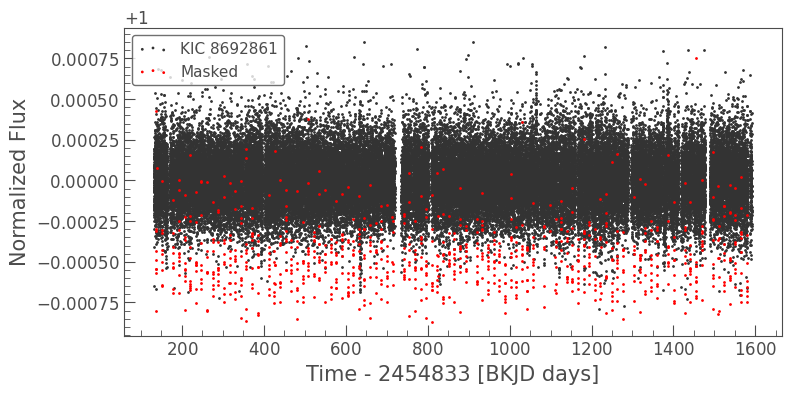

In [9]:
masked_lc = lc[~planet_b_mask]
ax = masked_lc.scatter();
lc[planet_b_mask].scatter(ax=ax, c='r', label='Masked');

We can also create a BLS model to visualize the transit fit. This returns a `LightCurve` object with the BLS model in the flux column.

In [10]:
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period, 
                                       transit_time=planet_b_t0, 
                                       duration=planet_b_dur)

We can plot this over the folded light curve to confirm that it accurately represents the transit.

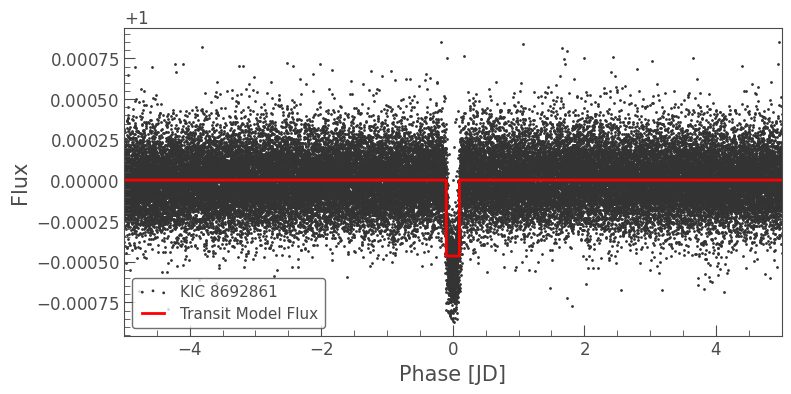

In [11]:
ax = lc.fold(planet_b_period, planet_b_t0).scatter()
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-5, 5);

## 5. Identifying Additional Transiting Planet Signals in the Same Light Curve

Now that we have created a light curve with the first identified planet masked out, we can search the remaining light curve for additional transit signals. Here, we search for long-period planets by increasing our range of periods to 1–300 days.

`period` contains 4246016 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


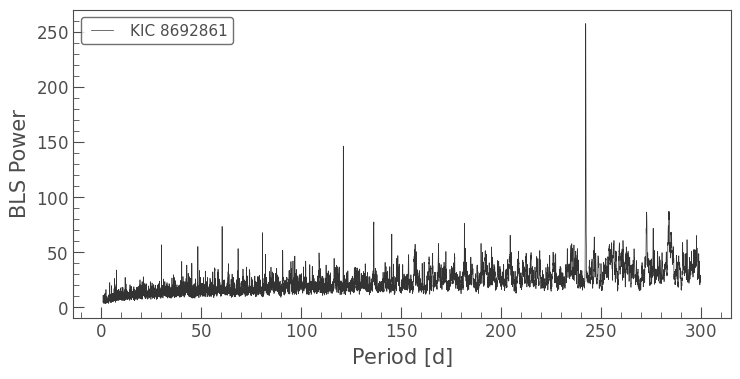

In [12]:
period = np.linspace(1, 300, 10000)
bls = masked_lc.to_periodogram('bls', period=period)
bls.plot();

While no peaks in this BLS periodogram display a power as high as the previous transit signal, there is a definite peak near ~240 days. We can pull out the corresponding period and transit time to check the signal.

In [13]:
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 242.46664666 d>

We can again plot the phase-folded light curve to examine the transit.

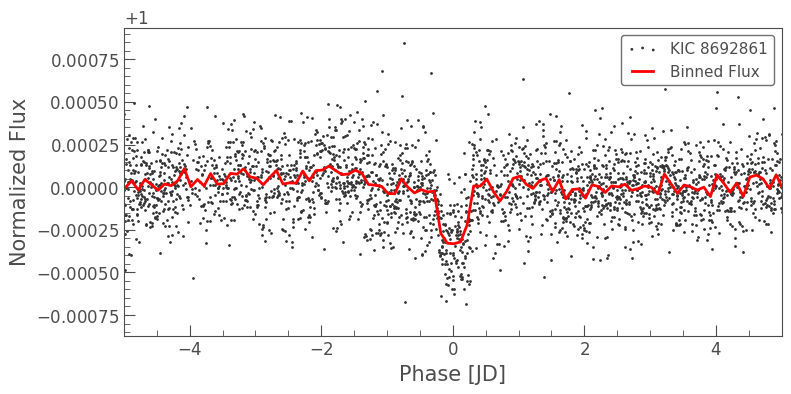

In [14]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()
masked_lc.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, c='r', lw=2, 
                                                          label='Binned Flux')
ax.set_xlim(-5, 5);

This signal is lower SNR because there are fewer transits due to the longer period, and the shallower depth implies that the planet is smaller. To help see the transit more clearly, we have overplotted the binned flux, combining consecutive points taken over a span of 0.1 days.

We have now successfully identified two planets in the same system! We can use the BLS models to visualize the transit timing in the light curve.

In [15]:
planet_c_model = bls.get_transit_model(period=planet_c_period, 
                                       transit_time=planet_c_t0, 
                                       duration=planet_c_dur)

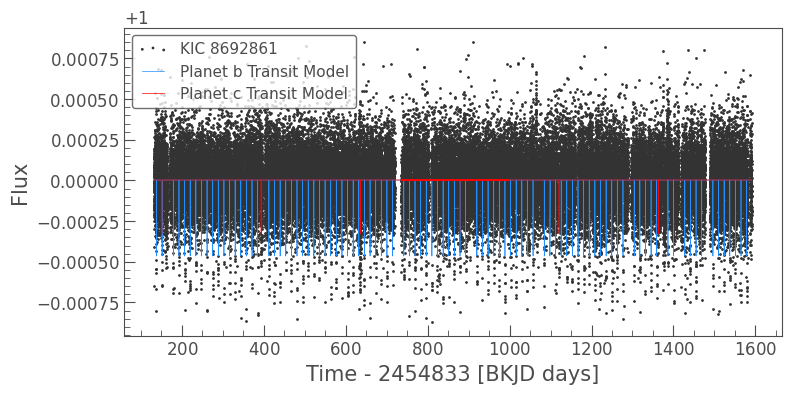

In [16]:
ax = lc.scatter();
planet_b_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');

## 6. Using the Interactive BLS Periodogram in Lightkurve

Lightkurve also has a tool that enables you to interactively perform a BLS search. A quick demo of this feature is shown below. For more information about the interactive BLS periodogram, please see the [Lightkurve documentation](http://docs.lightkurve.org/api/lightkurve.lightcurve.FoldedLightCurve.html#lightkurve.lightcurve.FoldedLightCurve.interact_bls).

To use the `LightCurve.interact_bls()` method, zoom in on peaks in the BLS periodogram using the interactive plotting tools. To improve the fit, you can change the transit duration. The phase-folded light curve panel in the top right and the full light curve below it will automatically update to plot the highest power BLS model. The BLS parameters with highest power are noted in the bottom right of the figure.

![interact_bls() demo animation](interact_bls.gif)

## About this Notebook

**Authors:** Nicholas Saunders (nksaun@hawaii.edu)

**Updated On:** 2020-09-28

# Citing Lightkurve and Astropy

If you use `lightkurve` or its dependencies in your published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [17]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
